#   Satellite Image Classification | CNN | Fine Tuning NasNet Mobile - %95 Accuracy

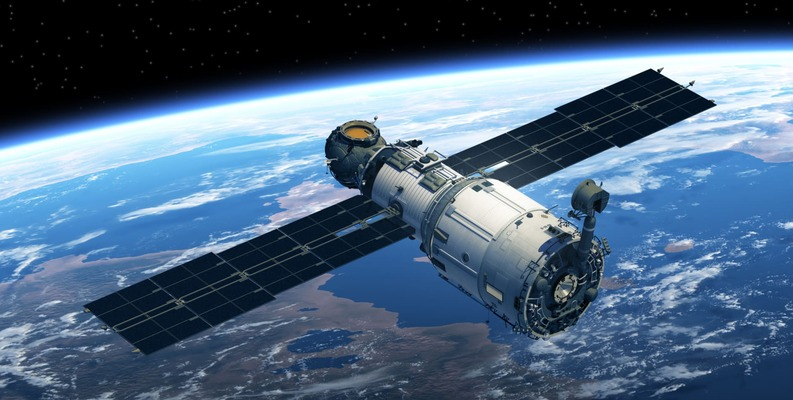

# Introduction

The "Satellite Image Classification" dataset on Kaggle is a collection of satellite images labeled with classes such as "Cloudy", "Desert", "Green_Area", and "Water".

Dataset Description: This dataset consists of satellite images of size 256x256 pixels. Each image is categorized into four classes. Provide details about the dataset source (Kaggle) and its general composition.


Objective: The goal is to achieve high accuracy in classifying satellite images using Convolutional Neural Networks (CNN) and transfer learning techniques such as fine-tuning with NASNetMobile.

# Importing Libraries

In [1]:
import keras
import tensorflow as tf
print("Keras Current Version:", keras.__version__, "Tensorflow Current Version:", tf.__version__)

Keras Current Version: 3.3.3 Tensorflow Current Version: 2.16.1


In [2]:
from glob import glob
import random, os, datetime

import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import layers, metrics
from tensorflow.keras.preprocessing import image
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models  import Sequential, load_model
from tensorflow.keras.metrics import Accuracy, AUC

from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [3]:
def get_image_paths(root_dir, num_images=None):
    all_images = []
    for extension in ['*.jpg', '*.jpeg', '*.png']:
        all_images.extend(glob(os.path.join(root_dir, '**', extension), recursive=True))
    if num_images is None:
        return all_images
    else:
        return random.sample(all_images, min(num_images, len(all_images)))


def display_images(img_list):
    plt.figure(figsize=(15, 6))
    for i, img_path in enumerate(img_list):
        img = image.load_img(img_path)
        img = image.img_to_array(img, dtype=np.uint8)
        plt.subplot(2, 5, i + 1)
        plt.imshow(img.squeeze())
        plt.axis('off')
        plt.title(f'Image {i+1}')
    plt.tight_layout()
    plt.show()


In [4]:
path = "/kaggle/input/satellite-image-classification/data/"


In [5]:
#from google.colab import drive
#drive.mount('/content/drive')

In [6]:
#dir_path = '/content/drive/MyDrive/Colab Notebooks/satellite_data'
dir_path = "/kaggle/input/satellite-image-classification/data/"


In [7]:
img_list = get_image_paths(dir_path)

print(len(img_list))

5631


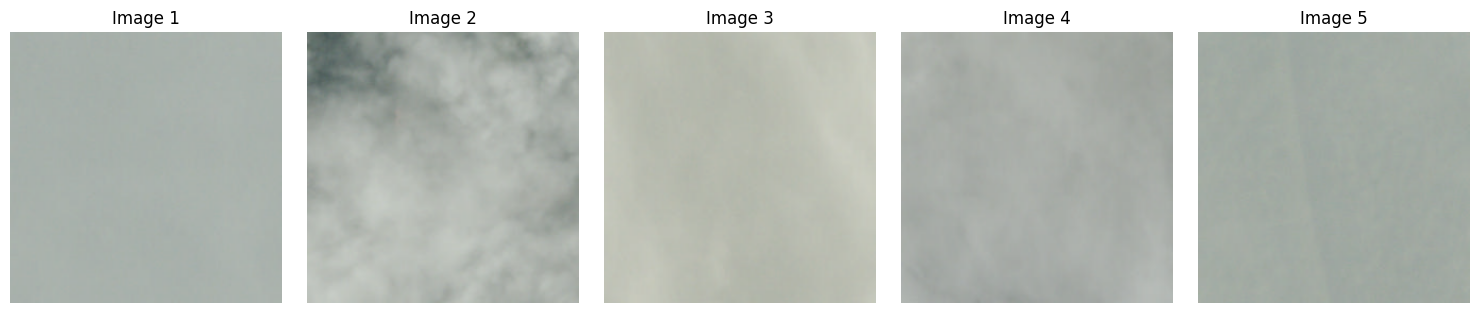

In [8]:
display_images(img_list[0:5])

# Train / Validation Sets

In [9]:
train = ImageDataGenerator(horizontal_flip=True,
                         vertical_flip=True,
                         validation_split=0.1,
                         rescale=1./255,
                         shear_range = 0.1,
                         zoom_range = 0.1,
                         width_shift_range = 0.1,
                         height_shift_range = 0.1,)

val = ImageDataGenerator(rescale=1/255,
                        validation_split=0.1)


In [10]:
train_generator=train.flow_from_directory(dir_path,
                                          target_size=(224, 224),
                                          batch_size=32,
                                          class_mode='categorical',
                                          subset='training')

validation_generator=val.flow_from_directory(dir_path,
                                        target_size=(224, 224),
                                        batch_size=563,
                                        class_mode='categorical',
                                        subset='validation')

Found 5068 images belonging to 4 classes.
Found 563 images belonging to 4 classes.


# Creating CNN Model

Model Architecture: Explain the architecture of the CNN model developed initially (e.g., input layer, convolutional layers, pooling layers, fully connected layers, and output layer).

In [11]:
from tensorflow.keras import layers, models, optimizers

# Modeli tanımla
model = models.Sequential([
    layers.Input(shape=(224, 224, 3)),
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(256, (3, 3), activation='relu'),  # Ekstra Convolutional Katman
    layers.GlobalAveragePooling2D(),  # Flatten yerine Global Average Pooling
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.4),  # Dropout oranını artırdık
    layers.Dense(4, activation='softmax'),
])

# Optimize edici, kayıp fonksiyonu ve metrikler
metrics = [
    "accuracy",
    AUC(name='auc', multi_label=True)
]

# Daha düşük bir öğrenme oranı ile optimize edici
optimizer = optimizers.Adam(learning_rate=0.0001)  # Öğrenme oranını düşürdük

model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=metrics)

# Erken durdurma ve model kontrol noktası
early_stopping = EarlyStopping(monitor='val_loss',
                               patience=15,  # Sabırlılık süresini artırdık
                               verbose=1,
                               restore_best_weights=True)

model_checkpoint = ModelCheckpoint(filepath='satellite.keras',
                                   monitor='val_loss',
                                   save_best_only=True,
                                   save_weights_only=False,
                                   verbose=1)


In [12]:
start_time = datetime.datetime.now()

history = model.fit(train_generator,
                    epochs=30,
                    validation_data=validation_generator,
                    callbacks=[early_stopping, model_checkpoint])

end_time = datetime.datetime.now()
total_duration = end_time - start_time
print("Trainin Time:", total_duration)

Epoch 1/30


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1725910881.392083      84 service.cc:145] XLA service 0x7f965800dfd0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1725910881.392143      84 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1725910881.392147      84 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5


  1/159 ━━━━━━━━━━━━━━━━━━━━ 37:29 14s/step - accuracy: 0.3438 - auc: 0.5663 - loss: 1.3752

I0000 00:00:1725910888.973828      84 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


158/159 ━━━━━━━━━━━━━━━━━━━━ 0s 530ms/step - accuracy: 0.3899 - auc: 0.8079 - loss: 1.1502
Epoch 1: val_loss improved from inf to 0.53509, saving model to satellite.keras
159/159 ━━━━━━━━━━━━━━━━━━━━ 119s 662ms/step - accuracy: 0.3917 - auc: 0.8086 - loss: 1.1471 - val_accuracy: 0.8277 - val_auc: 0.9456 - val_loss: 0.5351
Epoch 2/30
159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 341ms/step - accuracy: 0.7038 - auc: 0.9128 - loss: 0.5413
Epoch 2: val_loss did not improve from 0.53509
159/159 ━━━━━━━━━━━━━━━━━━━━ 58s 352ms/step - accuracy: 0.7038 - auc: 0.9128 - loss: 0.5413 - val_accuracy: 0.6377 - val_auc: 0.9624 - val_loss: 0.5460
Epoch 3/30
159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 340ms/step - accuracy: 0.7466 - auc: 0.9302 - loss: 0.4997
Epoch 3: val_loss improved from 0.53509 to 0.41872, saving model to satellite.keras
159/159 ━━━━━━━━━━━━━━━━━━━━ 58s 351ms/step - accuracy: 0.7468 - auc: 0.9303 - loss: 0.4995 - val_accuracy: 0.8526 - val_auc: 0.9655 - val_loss: 0.4187
Epoch 4/30
159/159 ━━━━━━━━━━━━━━━━━━

# Model Evaluation and Performance

Metrics: Define the metrics used to evaluate the model (e.g., accuracy, precision, recall, F1-score). Mention why accuracy alone may not be enough in

Validation Loss and Accuracy: Track the validation loss and accuracy over the epochs and discuss any signs of overfitting or underfitting.

In [13]:
val_loss, val_accuracy, val_auc = model.evaluate(validation_generator, verbose=0)
print(f"Loss: {val_loss}")
print(f"Accuracy: {val_accuracy}")
print(f"AUC: {val_auc}")

Loss: 0.21380239725112915
Accuracy: 0.9289520382881165
AUC: 0.9875490665435791


In [14]:
def plot_training_history(history, train_loss='loss', train_metric='accuracy', val_loss='val_loss', val_metric='val_accuracy'):

    #Loss
    plt.figure(figsize=(10, 5))
    plt.plot(history.history[train_loss], label='Training Loss')
    plt.plot(history.history[val_loss], label='Validation Loss')
    plt.title('Training and Validation Loss Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    # Metrics
    plt.figure(figsize=(10, 5))
    plt.plot(history.history[train_metric], label=f"Training: {train_metric}")
    plt.plot(history.history[val_metric], label=f"Validation: {val_metric}")
    plt.title(f'Training and Validation {train_metric} Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel(f'train_metric')
    plt.legend()
    plt.show()

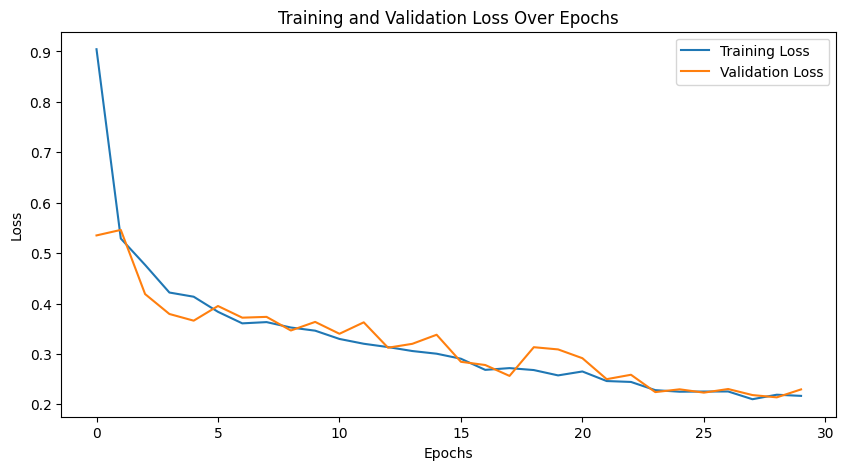

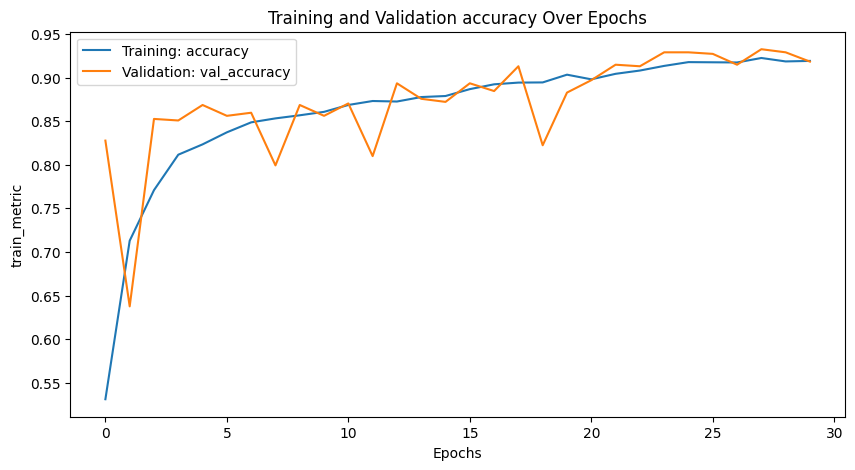

In [15]:
plot_training_history(history, train_loss='loss', train_metric='accuracy', val_loss='val_loss', val_metric='val_accuracy')

# Fine Tuning with NASNetMobile

In [16]:
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.metrics import Accuracy
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Conv2D, Flatten, MaxPooling2D, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.applications.nasnet import NASNetMobile, preprocess_input as preprocess_input_nasnet

In [17]:
base_model = NASNetMobile(weights='imagenet',
                            include_top=False,
                            input_shape=(224, 224, 3))

19993432/19993432 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [18]:
base_model.summary()

Model: "NASNet"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv1 (Conv2D) │ (None, 111, 111,  │        864 │ input_layer_1[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn1            │ (None, 111, 111,  │        128 │ stem_conv1[0][0]  │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 111, 111,  │          0 │ stem_bn1[0][0]    │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reduction_conv_1_s… │ (None, 111, 111,  │        352 │ activation[0][0]  │
│ (Conv2D)            │ 11)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reduction_bn_1_ste… │ (None, 111, 111,  │         44 │ reduction_conv_1… │
│ (BatchNormalizatio… │ 11)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 111, 111,  │          0 │ reduction_bn_1_s… │
│ (Activation)        │ 11)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 111, 111,  │          0 │ stem_bn1[0][0]    │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv_1_p… │ (None, 115, 115,  │          0 │ activation_1[0][… │
│ (ZeroPadding2D)     │ 11)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv_1_p… │ (None, 117, 117,  │          0 │ activation_3[0][… │
│ (ZeroPadding2D)     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv_1_r… │ (None, 56, 56,    │        396 │ separable_conv_1… │
│ (SeparableConv2D)   │ 11)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv_1_r… │ (None, 56, 56,    │      1,920 │ separable_conv_1… │
│ (SeparableConv2D)   │ 11)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv_1_b… │ (None, 56, 56,    │         44 │ separable_conv_1… │
│ (BatchNormalizatio… │ 11)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv_1_b… │ (None, 56, 56,    │         44 │ separable_conv_1… │
│ (BatchNormalizatio… │ 11)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 56, 56,    │          0 │ separable_conv_1… │
│ (Activation)        │ 11)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_4        │ (None, 56, 56,    │          0 │ separable_conv_1… │
│ (Activation)        │ 11)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv_2_r… │ (None, 56, 56,    │        396 │ activation_2[0][

 Total params: 4,269,716 (16.29 MB)

 Trainable params: 4,232,978 (16.15 MB)

 Non-trainable params: 36,738 (143.51 KB)

Fine-Tuning Strategy: Explain the process of fine-tuning the model. This may include freezing certain layers of NASNetMobile and retraining only the top layers, followed by unfreezing and fine-tuning the entire model.

In [19]:
for layer in base_model.layers:
    layer.trainable = False

In [20]:
for layer in base_model.layers[-10:]:
    layer.trainable = True

In [21]:
x = GlobalAveragePooling2D()(base_model.output)

x = Dense(4, activation='softmax')(x)

fine_tuning_model = Model(inputs=base_model.input, outputs=x)

In [22]:
optimizer=SGD(learning_rate=0.0001, momentum=0.9, nesterov=True)

fine_tuning_model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=["accuracy"])

In [23]:
early_stopping = EarlyStopping(monitor='val_loss',
                               patience=10,
                               restore_best_weights=True,
                               verbose=1)


model_checkpoint = ModelCheckpoint('NASNetMobile_finetuned.keras',
                                   monitor='val_loss',
                                   save_best_only=True,
                                   save_weights_only=False,
                                   verbose=1)

In [24]:
start_time = datetime.datetime.now()

fine_tuning_model_history = fine_tuning_model.fit(
    train_generator,
    epochs=50,
    validation_data=validation_generator,
    callbacks=[early_stopping, model_checkpoint]
)

end_time = datetime.datetime.now()

total_duration = end_time - start_time
print("Training Time:", total_duration)

Epoch 1/50
159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 464ms/step - accuracy: 0.2702 - loss: 1.4322

2024-09-09 20:13:58.911062: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng30{k2=2,k4=2,k5=0,k6=0,k7=0} for conv (f32[563,32,56,56]{3,2,1,0}, u8[0]{0}) custom-call(f32[563,32,111,111]{3,2,1,0}, f32[32,1,7,7]{3,2,1,0}), window={size=7x7 stride=2x2 pad=3_3x3_3}, dim_labels=bf01_oi01->bf01, feature_group_count=32, custom_call_target="__cudnn$convForward", backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0}} is taking a while...
2024-09-09 20:13:59.182970: E external/local_xla/xla/service/slow_operation_alarm.cc:133] The operation took 1.272064903s
Trying algorithm eng30{k2=2,k4=2,k5=0,k6=0,k7=0} for conv (f32[563,32,56,56]{3,2,1,0}, u8[0]{0}) custom-call(f32[563,32,111,111]{3,2,1,0}, f32[32,1,7,7]{3,2,1,0}), window={size=7x7 stride=2x2 pad=3_3x3_3}, dim_labels=bf01_oi01->bf01, feature_group_count=32, custom_call_target=


Epoch 1: val_loss improved from inf to 1.18524, saving model to NASNetMobile_finetuned.keras
159/159 ━━━━━━━━━━━━━━━━━━━━ 172s 833ms/step - accuracy: 0.2708 - loss: 1.4316 - val_accuracy: 0.4867 - val_loss: 1.1852
Epoch 2/50
159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 402ms/step - accuracy: 0.6299 - loss: 1.0697
Epoch 2: val_loss improved from 1.18524 to 0.99303, saving model to NASNetMobile_finetuned.keras
159/159 ━━━━━━━━━━━━━━━━━━━━ 71s 428ms/step - accuracy: 0.6301 - loss: 1.0694 - val_accuracy: 0.6625 - val_loss: 0.9930
Epoch 3/50
159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 395ms/step - accuracy: 0.7526 - loss: 0.8847
Epoch 3: val_loss improved from 0.99303 to 0.86880, saving model to NASNetMobile_finetuned.keras
159/159 ━━━━━━━━━━━━━━━━━━━━ 81s 424ms/step - accuracy: 0.7527 - loss: 0.8845 - val_accuracy: 0.6963 - val_loss: 0.8688
Epoch 4/50
159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 387ms/step - accuracy: 0.7903 - loss: 0.7595
Epoch 4: val_loss improved from 0.86880 to 0.78206, saving model to NASNetMobile_finetu

## Model Evaluation and Performance

In [25]:
val_loss, val_accuracy = fine_tuning_model.evaluate(validation_generator, verbose=0)
print(f"Loss: {val_loss}")
print(f"Accuracy: {val_accuracy}")

Loss: 0.252640962600708
Accuracy: 0.9431616067886353


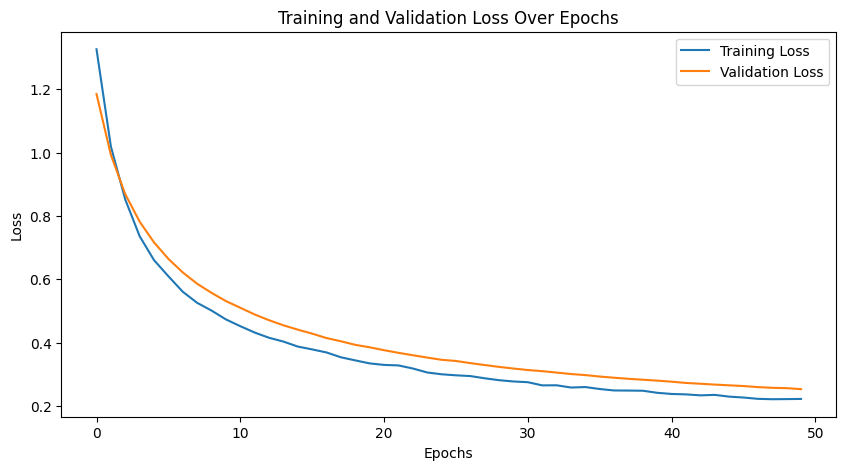

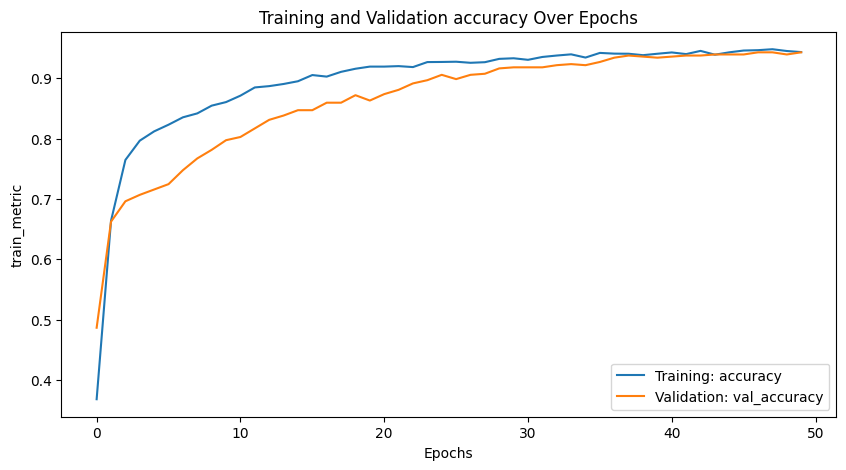

In [26]:
plot_training_history(fine_tuning_model_history, train_loss='loss', train_metric='accuracy', val_loss='val_loss', val_metric='val_accuracy')